# Explore here

In [1]:
# Importamos Librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from imblearn.metrics import specificity_score
from sklearn.model_selection import GridSearchCV

# Datos

In [2]:
# Cargamos el dataframe
df = pd.read_csv('../data/raw/playstore_reviews.csv')
                 
# Exploramos los datos
df.head()

,package_name,review,polarity
0,com.facebook.katana,privacy at least put some option appear offli...,0
1,com.facebook.katana,"messenger issues ever since the last update, ...",0
2,com.facebook.katana,profile any time my wife or anybody has more ...,0
3,com.facebook.katana,the new features suck for those of us who don...,0
4,com.facebook.katana,forced reload on uploading pic on replying co...,0


In [3]:
# Eliminar la columna package_name
df = df.drop('package_name', axis=1)

In [4]:
# Procesamos el texto
df["review"] = df["review"].str.strip().str.lower()

In [5]:
# Dividir datos en características (X) y etiqueta (y)
X = df['review']
y = df['polarity']

In [6]:
# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
# Transformar el texto en una matriz de recuento de palabras
vec_model = CountVectorizer(stop_words="english")
X_train_vec = vec_model.fit_transform(X_train).toarray()
X_test_vec = vec_model.transform(X_test).toarray()

# Metricas de Evaluación

In [8]:
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

    # Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

    # Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    # Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],[test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
                              index = ['Train','Test', 'Diferencia'])

    return metrics_df

# Naive Bayes

In [9]:
# Modelos de Naive Bayes
models = {
    "GaussianNB": GaussianNB(),
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB()}

In [10]:
# Entrenamiento de cada modelo
for name, model in models.items():
    model.fit(X_train_vec, y_train)

In [11]:
# Predicción y métricas de Evaluación de cada modelo
for name, model in models.items():
    test_pred = model.predict(X_test_vec)
    train_pred = model.predict(X_train_vec)
    print(f"Modelo {name}:")
    print(get_metrics(y_train, y_test, train_pred, test_pred))
    print("-" * 50)

Modelo GaussianNB:
            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.981742  0.974155  0.986081   0.949612  1.000000     0.972163
Test        0.815642  0.717949  0.783154   0.763636  0.677419     0.888889
Diferencia  0.166099  0.256206  0.202927   0.185976  0.322581     0.083274
--------------------------------------------------
Modelo MultinomialNB:
            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.955056  0.933884  0.947306   0.945607  0.922449     0.972163
Test        0.854749  0.759259  0.809278   0.891304  0.661290     0.957265
Diferencia  0.100308  0.174625  0.138028   0.054302  0.261159     0.014898
--------------------------------------------------
Modelo BernoulliNB:
            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.924157  0.876712  0.890766   0.994819  0.783673     0.997859
Test        0.782123  0.580645  0.700648   0.870968  0.435484     0.965812
Diferencia  

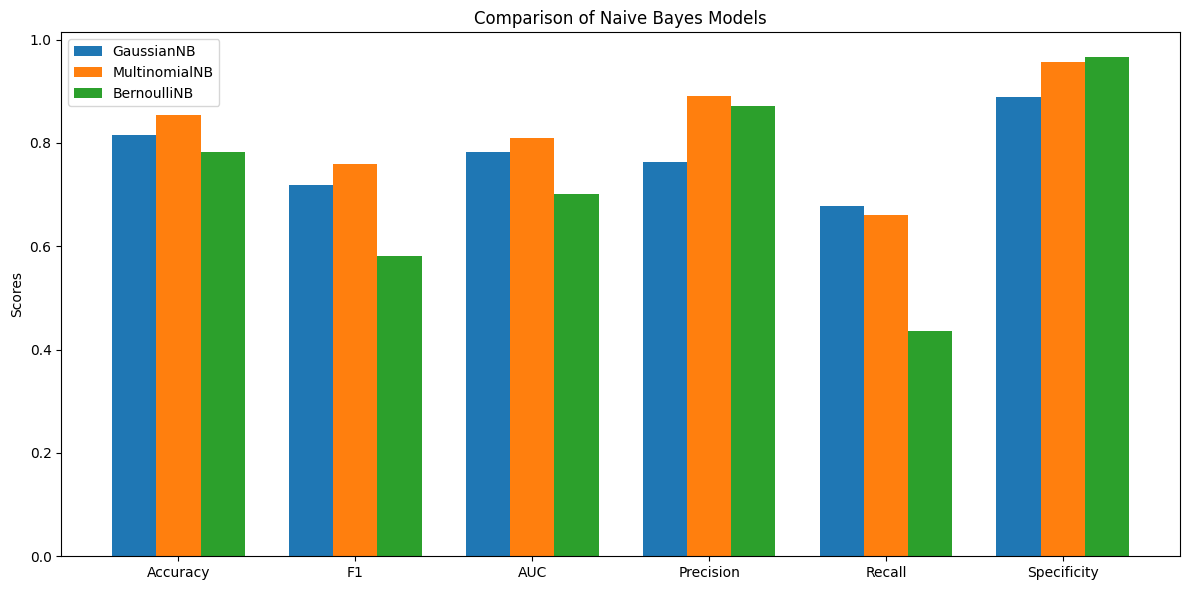

In [12]:
# Gráfico de barras para cada variante de Naive Bayes
models = ['GaussianNB', 'MultinomialNB', 'BernoulliNB']
metrics = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity']

# Datos de test para cada modelo
gaussian_test = [0.815642, 0.717949, 0.783154, 0.763636, 0.677419, 0.888889]
multinomial_test = [0.854749, 0.759259, 0.809278, 0.891304, 0.661290, 0.957265]
bernoulli_test = [0.782123, 0.580645, 0.700648, 0.870968, 0.435484, 0.965812]

x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, gaussian_test, width, label='GaussianNB')
rects2 = ax.bar(x, multinomial_test, width, label='MultinomialNB')
rects3 = ax.bar(x + width, bernoulli_test, width, label='BernoulliNB')

ax.set_ylabel('Scores')
ax.set_title('Comparison of Naive Bayes Models')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()


Este análisis sugiere que MultinomialNB es la mejor opción base, pero con margen para mejora mediante ajuste de hiperparámetros.

# Hiperparametros

In [13]:
# Optimización para MultinomialNB

params = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
          'fit_prior': [True, False]}

grid = GridSearchCV(MultinomialNB(), params, cv=5, scoring='f1')
grid.fit(X_train_vec, y_train)

best_model = grid.best_estimator_
print(f"Mejores parámetros: {grid.best_params_}")

Mejores parámetros: {'alpha': 0.5, 'fit_prior': False}


In [14]:
# Predicción de modelo optimizado
test_pred_b = best_model.predict(X_test_vec)
train_pred_b = best_model.predict(X_train_vec)

In [15]:
# Métricas de evaluación del modelo optimizado
print("Modelo optimizado:")
print(get_metrics(y_train, y_test, train_pred_b, test_pred_b))

Modelo optimizado:
            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.962079  0.945233  0.959450   0.939516  0.951020     0.967880
Test        0.882682  0.823529  0.860973   0.859649  0.790323     0.931624
Diferencia  0.079397  0.121704  0.098477   0.079867  0.160698     0.036256


# Save los Archivos

In [16]:
# Guardamos el modelo
from pickle import dump

dump(best_model, open("../models/NaiveBayes.sav", "wb"))

# Conclusiones

Con la optimización se mejoró el rendimiento en test manteniendo capacidad de generalización.

El modelo optimizado es ahora más adecuado para un entorno real, especialmente si la detección de comentarios positivos/negativos requiere equilibrio entre precisión y cobertura.